# Text classification

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import torch
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Required the first time
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

## Exploring data

In [3]:
# Ignoring index column
df_train = pd.read_csv('/kaggle/input/fake-news-classification/train (2).csv', sep=';', usecols=['title','text','label'])
df_eval = pd.read_csv('/kaggle/input/fake-news-classification/evaluation.csv', sep=';', usecols=['title','text','label'])
df_test = pd.read_csv('/kaggle/input/fake-news-classification/test (1).csv', sep=';', usecols=['title','text','label'])

In [4]:
print('Shape train:', df_train.shape)
print('Shape evaluation:', df_eval.shape)
print('Shape test:', df_test.shape)

Shape train: (24353, 3)
Shape evaluation: (8117, 3)
Shape test: (8117, 3)


In [5]:
# Union all frames for exploration
df_full = pd.concat([df_train, df_eval, df_test])

print('Distribution on label:\n',df_full['label'].value_counts())

print('Maximum title length (ignoring whitespace):',df_full['title'].str.replace(' ','').apply(len).max())
print('Maximum text length (ignoring whitespace):',df_full['text'].str.replace(' ','').apply(len).max())

Distribution on label:
 label
1    21924
0    18663
Name: count, dtype: int64
Maximum title length (ignoring whitespace): 372
Maximum text length (ignoring whitespace): 43359


Title seems long enough to be used, but text seems like it will need to be truncated.
Supposing whitespace splits words, we can estimate word counting splitting whitespaces into vector of words and counting vector length.

0.20     157.0
0.50     367.0
0.90     746.0
0.95     904.0
1.00    8135.0
Name: text, dtype: float64


<Axes: >

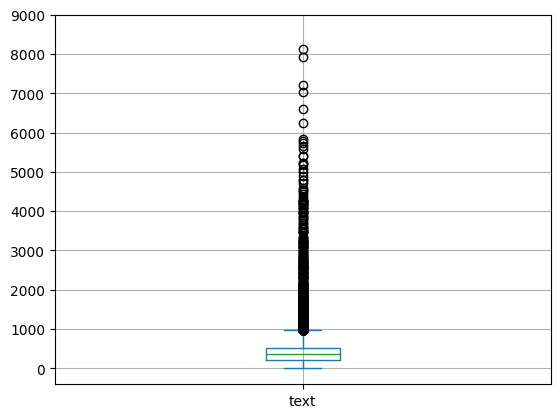

In [6]:
# Distribution of text number of words
text_len_series = df_full['text'].apply(lambda x: len(x.split()))
print(text_len_series.quantile([0.2,0.5,0.9,0.95,1]))

text_len_series.plot.box(yticks=np.arange(0,10000, step=1000), grid=True)

Half of the texts have at least around 370 words and 90% of the texts have around 750 words. Seems like texts are mostly long enough for tokenizer use too. After this quick exploration, let's start with NLP!

## NLP & LSTM

### NLP

In [7]:
def plot_training_performance(history):
    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history.get('accuracy', history.history.get('binary_accuracy'))
    val_accuracy = history.history.get('val_accuracy', history.history.get('val_binary_accuracy'))

    # Plot loss
    plt.figure(figsize=(12, 5))

    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss', marker='o')
    plt.plot(val_loss, label='Validation Loss', marker='o')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Subplot 2: Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy', marker='o')
    plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Show the plot
    plt.tight_layout()
    plt.show()

In [8]:
class TextPreprocessor:
    def __init__(self, language='english'):
        self.stop_words = set(stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def NormalizeTextCol(self, text):
        """Run the entire pipeline (normalize, tokenize, remove stopwords, lemmatize)."""
        text = self.normalize_text(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        # tokens = self.lemmatize_tokens(tokens)
        return tokens

    def normalize_text(self, text):
        """Normalize the text by converting to lowercase and removing punctuation and digits."""
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        return text

    def tokenize(self, text):
        """Tokenize the text into individual words."""
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """Remove stopwords from the tokenized text."""
        return [word for word in tokens if word not in self.stop_words]

    def lemmatize_tokens(self, tokens):
        """Lemmatize the tokens."""
        return [self.lemmatizer.lemmatize(word) for word in tokens]

In [9]:
class_text_normalizer = TextPreprocessor()

In [10]:
#Union eval and train
df_train = pd.concat([df_train, df_eval])

In [11]:
df_train['pre_processed_title'] = df_train['title'].apply(class_text_normalizer.NormalizeTextCol)
df_train['pre_processed_text'] = df_train['text'].apply(class_text_normalizer.NormalizeTextCol)

df_test['pre_processed_title'] = df_test['title'].apply(class_text_normalizer.NormalizeTextCol)
df_test['pre_processed_text'] = df_test['text'].apply(class_text_normalizer.NormalizeTextCol)

### LSTM

In [12]:
title_tokenizer = Tokenizer()
title_tokenizer.fit_on_texts(df_train['pre_processed_title'].apply(lambda x: ' '.join(x)))

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(df_train['pre_processed_text'].apply(lambda x: ' '.join(x)))

In [13]:
# Convert titles and texts to sequences
train_title_sequences = title_tokenizer.texts_to_sequences(df_train['pre_processed_title'].apply(lambda x: ' '.join(x)))
train_text_sequences = text_tokenizer.texts_to_sequences(df_train['pre_processed_text'].apply(lambda x: ' '.join(x)))

test_title_sequences = title_tokenizer.texts_to_sequences(df_test['pre_processed_title'].apply(lambda x: ' '.join(x)))
test_text_sequences = text_tokenizer.texts_to_sequences(df_test['pre_processed_text'].apply(lambda x: ' '.join(x)))

In [14]:
# Define maximum length for title and text
max_title_length = 64
max_text_length = 725

# Pad sequences to ensure consistent input size
X_train_title = pad_sequences(train_title_sequences, maxlen=max_title_length, padding='pre', truncating='pre')
X_train_text = pad_sequences(train_text_sequences, maxlen=max_text_length, padding='pre', truncating='pre')

X_test_title = pad_sequences(test_title_sequences, maxlen=max_title_length, padding='pre', truncating='pre')
X_test_text = pad_sequences(test_text_sequences, maxlen=max_text_length, padding='pre', truncating='pre')

y_train = df_train['label'].values
y_test = df_test['label'].values

In [15]:
# Define the LSTM model with two inputs for 'title' and 'text'
title_input = Input(shape=(max_title_length,), name='Title_Input')
text_input = Input(shape=(max_text_length,), name='Text_Input')

# Embedding and LSTM layers for each input
embedding_layer_title = Embedding(input_dim=len(title_tokenizer.word_index) + 1, output_dim=100)(title_input)
lstm_title = LSTM(64)(embedding_layer_title)

embedding_layer_text = Embedding(input_dim=len(text_tokenizer.word_index) + 1, output_dim=100)(text_input)
lstm_text = LSTM(128)(embedding_layer_text)

# Combine the outputs of both LSTM layers
combined = Concatenate()([lstm_title, lstm_text])

# Add a dense output layer for binary classification
output = Dense(1, activation='sigmoid')(combined)

# Build the model
model = Model(inputs=[title_input, text_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.02,
    patience=1,
    verbose=1,
    restore_best_weights=True
)

In [17]:
# Train the model
fit_history = model.fit(
    [X_train_title, X_train_text], y_train,
    epochs=5, batch_size=64, validation_split=0.2, verbose=1, callbacks=[early_stopping]
)

Epoch 1/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 27s 56ms/step - accuracy: 0.9035 - loss: 0.2344 - val_accuracy: 0.9791 - val_loss: 0.0723
Epoch 2/5
406/406 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.9864 - loss: 0.0427 - val_accuracy: 0.9720 - val_loss: 0.0800
Epoch 2: early stopping
Restoring model weights from the end of the best epoch: 1.


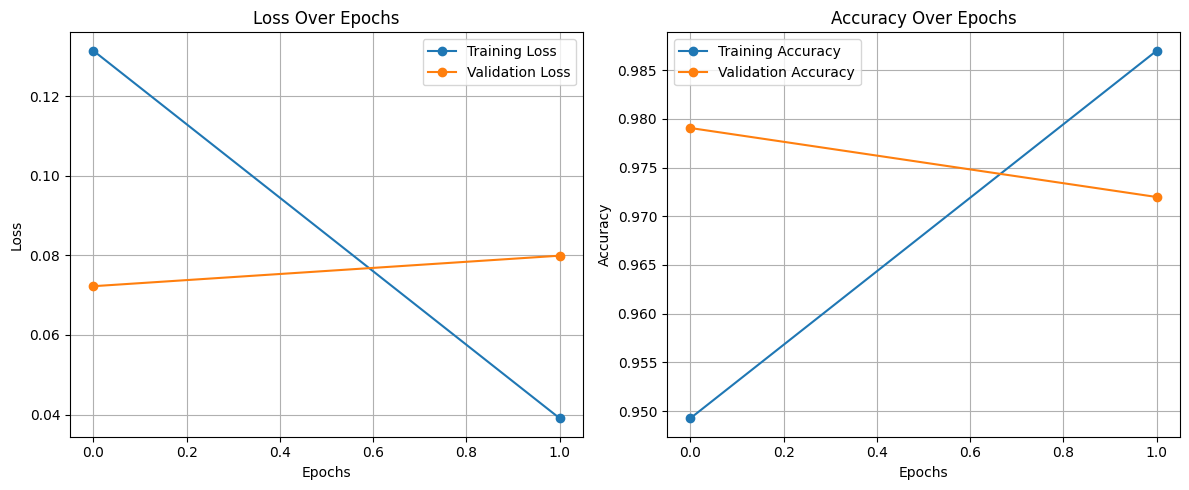

In [18]:
plot_training_performance(fit_history)

In [19]:
# Evaluate the model on test data
loss, accuracy = model.evaluate([X_test_title, X_test_text], y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9825


LSTM model got a really nice score on test dataframe. Now let's see how a transformers model deal with this classification task.

## Loading transformers models from HuggingFace

In [20]:
# Load tokenizer and pre-trained model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Freezing pre-trained params
for param in model.base_model.parameters():
    param.requires_grad = False

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
class TextPairDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_title_length, max_text_length):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_title_length = max_title_length
        self.max_text_length = max_text_length
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        title = str(self.data.iloc[idx]['title'])
        text = str(self.data.iloc[idx]['text'])
        label = int(self.data.iloc[idx]['label'])

        # Tokenize title and text
        title_encoding = self.tokenizer(
            title,
            truncation=True,
            padding='max_length',
            max_length=self.max_title_length,
            return_tensors='pt'
        )

        text_encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_text_length,
            return_tensors='pt'
        )
        
        # Return tokenized input and label
        return {
            'input_ids': title_encoding['input_ids'].flatten(),  
            'attention_mask': title_encoding['attention_mask'].flatten(),
            'text_input_ids': text_encoding['input_ids'].flatten(),
            'text_attention_mask': text_encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [22]:
# Using eval_accuracy as transformers evaluation metric for early stopping
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {
        "eval_accuracy": accuracy
    }

In [23]:
# Splitting train and eval for Trainer
df_train, df_eval = train_test_split(df_train, test_size=0.2, random_state=42)

# Creat datasets for Pytorch
train_dataset = TextPairDataset(df_train, tokenizer, max_title_length=max_title_length, max_text_length=max_text_length)

eval_dataset = TextPairDataset(df_train, tokenizer, max_title_length=max_title_length, max_text_length=max_text_length)

test_dataset = TextPairDataset(df_test, tokenizer, max_title_length=max_title_length, max_text_length=max_text_length)

In [24]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=0.001,
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy"
)

early_stopping_transformers = EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.02)

In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_transformers]
)

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.243900,0.191598,0.922929
2,0.185500,0.147182,0.941869
3,0.179200,0.142400,0.943332


TrainOutput(global_step=2436, training_loss=0.19442153329332473, metrics={'train_runtime': 523.1796, 'train_samples_per_second': 248.251, 'train_steps_per_second': 7.76, 'total_flos': 1290364930308096.0, 'train_loss': 0.19442153329332473, 'epoch': 3.0})

In [27]:
trainer.evaluate()

{'eval_accuracy': 0.9433323067446874,
 'eval_loss': 0.14240029454231262,
 'eval_runtime': 85.9946,
 'eval_samples_per_second': 302.066,
 'eval_steps_per_second': 9.442,
 'epoch': 3.0}

In [28]:
results = trainer.evaluate(test_dataset)

In [29]:
results

{'eval_accuracy': 0.9424664284834299,
 'eval_loss': 0.14828680455684662,
 'eval_runtime': 26.899,
 'eval_samples_per_second': 301.759,
 'eval_steps_per_second': 9.443,
 'epoch': 3.0}